# Analysis of minimal pairs and homophones


In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import statsmodels.formula.api as sm
import seaborn as sns
from tqdm import tqdm

import src.utils as utils
import src.config as config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

## Pipeline

Here, we define the general pipeline to analyze pre-processed lexicons (real and artificial).

In [3]:
NUM_ARTIFICIAL = 10

In [4]:
def get_stats_for_lexicon(df_lex):
    """Return basic stats about lexicon. Number of homophones, etc."""
    return {'homophone_percentage': round((len(df_lex[df_lex['num_homophones']>0]) / len(df_lex)), 4),
            'mean_homophones': round(df_lex['num_homophones'].mean(), 4),
            'max_homophones': round(df_lex['num_homophones'].max(), 2),
            'mean_mp': round(df_lex['neighborhood_size'].mean(), 4),
            'max_mp': round(df_lex['neighborhood_size'].max(), 2),
            'total_mp': round(df_lex['neighborhood_size'].sum(), 2),
            'mean_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].mean(), 4),
            'max_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].max(), 2),
            'total_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].sum(), 2)}

In [5]:
def process_and_extract_artificials(df_artificials, N=10, remove=True):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    mean_mp, max_mp, total_mp = [], [], []
    # Neighborhood size with homophones
    mean_mp_hp, max_mp_hp, total_mp_hp = [], [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp, verbose=False,
                                                          phon_column="word", word_column="word", remove=remove)
        
        lex_stats = get_stats_for_lexicon(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
        mean_mp.append(lex_stats['mean_mp'])
        max_mp.append(lex_stats['max_mp'])
        total_mp.append(lex_stats['total_mp'])
        mean_mp_hp.append(lex_stats['mean_mp_w_hp'])
        max_mp_hp.append(lex_stats['max_mp_w_hp'])
        total_mp_hp.append(lex_stats['total_mp_w_hp'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentage': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones,
            'mean_mp': mean_mp,
            'max_mp': max_mp,
            'total_mp': total_mp,
            'mean_mp_w_hp': mean_mp_hp,
            'max_mp_w_hp': max_mp_hp,
            'total_mp_w_hp': total_mp_hp
           }
    

In [6]:
def plot_real_vs_art(art_dist, real_value, statistic, language, ylabel="Count"):
    """Compare distribution of test statistics from artificial lexicon to real lexicon."""
    
    print("Mean of artificial: {x}.".format(x=statistics.mean(art_dist)))
    print("Median of artificial: {x}.".format(x=statistics.median(art_dist)))
    print("Standard deviation of artificial: {x}.".format(x=statistics.stdev(art_dist)))
    print("Range of artificial: ({x}, {y}).".format(x=min(art_dist), y=max(art_dist)))
    print("Real value: {x}.".format(x=real_value))
    
    plt.hist(art_dist)
    plt.title("{lan}: {x} (real vs. artificial)".format(lan=language, x=statistic))
    plt.xlabel(statistic)
    plt.ylabel(ylabel)
    plt.axvline(x=real_value, linestyle="dotted", color="red")
    # plt.axvline(x=0, linestyle="dashed", color="blue")

In [10]:
def load_lexicons_for_language(language, phon_column="PhonDISC", 
                               word_column="Word", nphones=5):
    """Loads lexicons for a given language."""
    df_real = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_all_mps_{n}phone.csv".format(lan1=language,
                                                                                         lan2=language, n=nphones))
    df_real_processed = utils.preprocess_for_analysis(df_real, word_column=word_column, phon_column=phon_column)
    df_artificials = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_artificial_10_matched_on_sylls_mps_no_restriction_{n}phone.csv".format(lan1=language,
                                                                                                                  lan2=language, n=nphones))

    return df_real, df_real_processed, df_artificials
    

In [8]:
def analyze_stats(df_og, list_of_artificials, formula, covariates):
    """Analyze stats for real vs artificial dataframes."""
    result_real = sm.poisson(formula=formula, 
                data=df_og).fit(disp=0)
    
    params = result_real.params
    params['real'] = "Yes"
    real_r2 = result_real.prsquared
    params['pr2'] = real_r2
    
    coefs = []
    coefs.append(params)
    
    for df_art in list_of_artificials:
        result_fake = sm.poisson(formula=formula, 
                data=df_art).fit(disp=0)
        fake_r2 = result_fake.prsquared
        params = result_fake.params
        params['real'] = "No"
        params['pr2'] = fake_r2
        coefs.append(params)
    
    return pd.DataFrame(coefs)

## English

In [11]:
df_celex, df_celex_processed, df_english_artificials = load_lexicons_for_language("english")

Number of tokens: 52437
Number of tokens: 41887


/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


Number of tokens: 35107


In [12]:
len(df_celex)

52438

In [13]:
len(df_celex_processed)

35107

In [14]:
df_english_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [15]:
info_for_english = process_and_extract_artificials(df_english_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


In [16]:
processed_artificials = info_for_english['processed_dataframes']

#### Norm surprisal

In [17]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

### `#homophones` ~ `rank_homophones`

In [331]:
rank_N = 1000

In [332]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['num_homophones'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'num_homophones': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

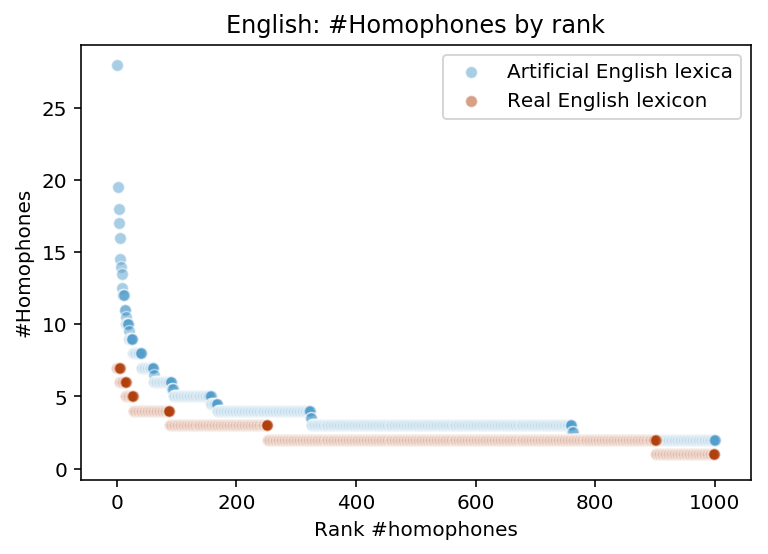

In [333]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial English lexica")

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real English lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("English: #Homophones by rank")

plt.savefig("Figures/english/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

In [348]:
rank_N = 1000

In [349]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['neighborhood_size'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'neighborhood_size': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

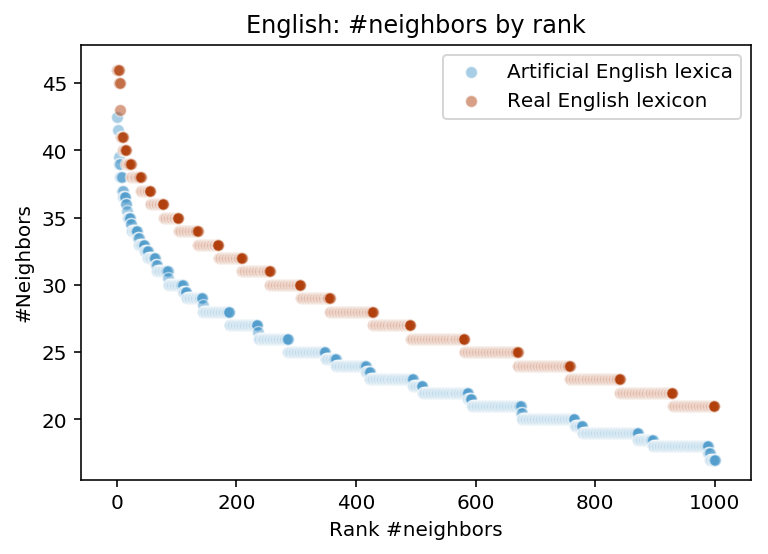

In [350]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial English lexica")

df_celex_processed['rank_num'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real English lexicon")
plt.xlabel("Rank #neighbors")
plt.ylabel("#Neighbors")
plt.title("English: #neighbors by rank")

plt.savefig("Figures/english/data_visualizations/rank_neighbors.png", dpi=300)

# German

In [40]:
df_celex, df_celex_processed, df_german_artificials = load_lexicons_for_language("german")

/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


In [41]:
len(df_celex)

51719

In [42]:
len(df_celex_processed)

50474

In [43]:
df_german_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [44]:
info_for_german = process_and_extract_artificials(df_german_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


In [45]:
processed_artificials = info_for_german['processed_dataframes']

#### Norm surprisal

In [46]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Visualizations

### `#homophones` ~ `rank_homophones`

In [47]:
rank_N = 1000

In [48]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['num_homophones'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'num_homophones': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

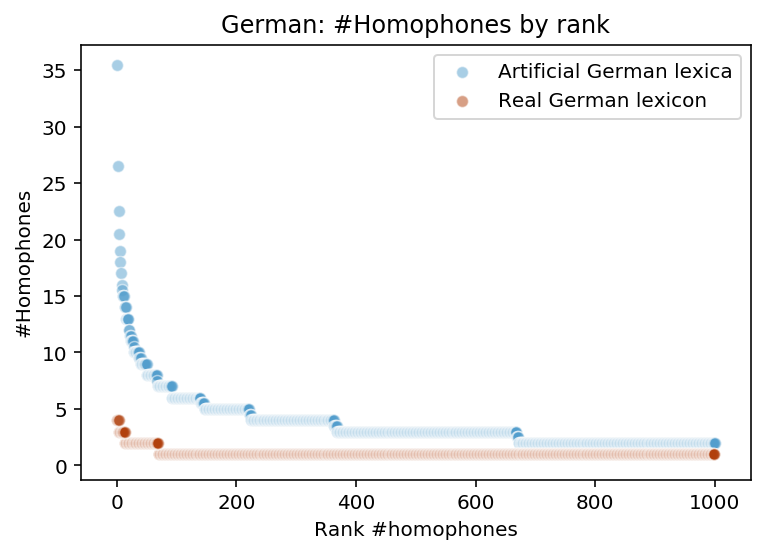

In [49]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial German lexica")

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real German lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("German: #Homophones by rank")

plt.savefig("Figures/german/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

In [50]:
rank_N = 1000

In [51]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['neighborhood_size'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'neighborhood_size': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

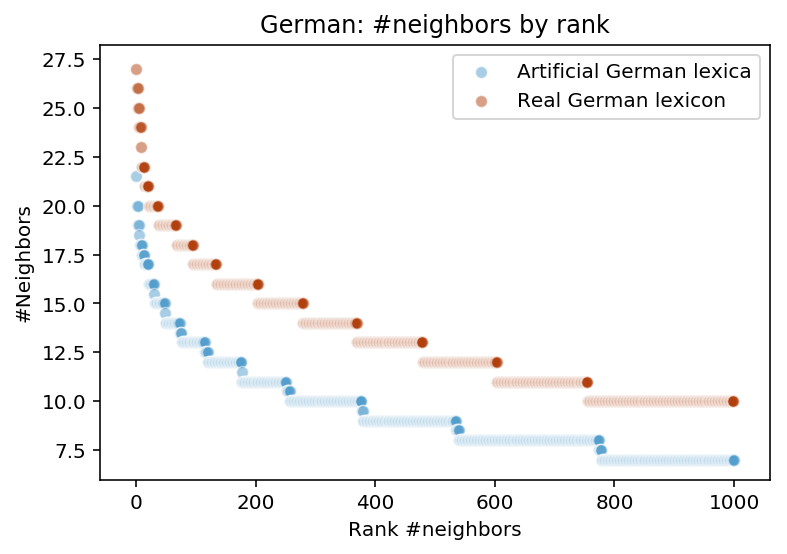

In [52]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial German lexica")

df_celex_processed['rank_num'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real German lexicon")
plt.xlabel("Rank #neighbors")
plt.ylabel("#Neighbors")
plt.title("German: #neighbors by rank")

plt.savefig("Figures/english/data_visualizations/rank_neighbors.png", dpi=300)

# Dutch

In [82]:
df_celex, df_celex_processed, df_dutch_artificials = load_lexicons_for_language("dutch")

In [83]:
len(df_celex)

67910

In [84]:
len(df_celex_processed)

65351

In [85]:
df_dutch_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [86]:
info_for_dutch = process_and_extract_artificials(df_dutch_artificials)

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


In [87]:
processed_artificials = info_for_dutch['processed_dataframes']

In [88]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Visualizations

### `#homophones` ~ `rank_homophones`

In [89]:
rank_N = 1000

In [90]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['num_homophones'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'num_homophones': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

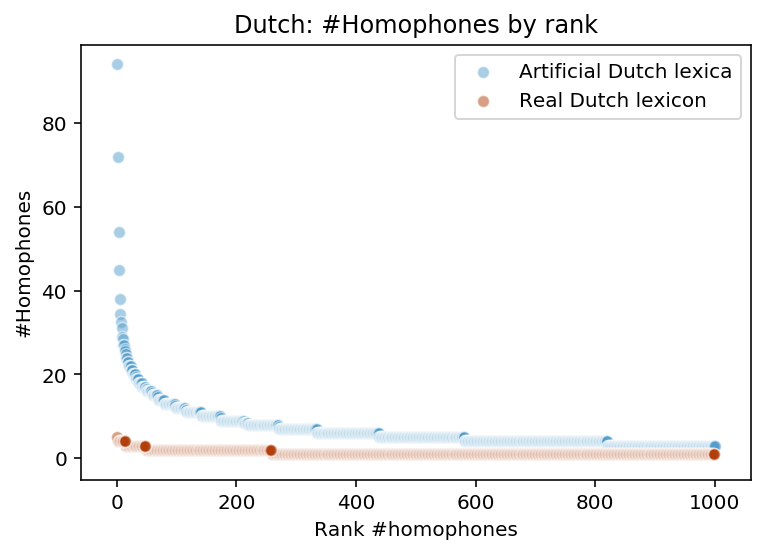

In [91]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial Dutch lexica")

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Dutch lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("Dutch: #Homophones by rank")

plt.savefig("Figures/dutch/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

In [64]:
rank_N = 1000

In [65]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['neighborhood_size'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'neighborhood_size': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

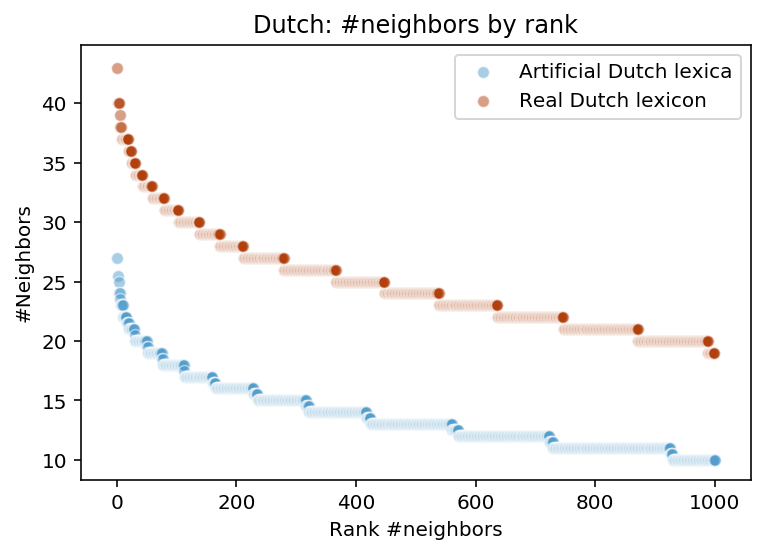

In [66]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial Dutch lexica")

df_celex_processed['rank_num'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Dutch lexicon")
plt.xlabel("Rank #neighbors")
plt.ylabel("#Neighbors")
plt.title("Dutch: #neighbors by rank")

plt.savefig("Figures/dutch/data_visualizations/rank_neighbors.png", dpi=300)

# French

In [67]:
import src.config as config

In [68]:
df_celex, df_celex_processed, df_french_artificials = load_lexicons_for_language("french", 
                                                                                word_column=config.WORD_COLUMN['french'], 
                                                                                phon_column=config.PHON_COLUMN['french'])

In [69]:
len(df_celex)

47310

In [70]:
len(df_celex_processed)

37278

In [71]:
df_french_stats = get_stats_for_lexicon(df_celex_processed)

### Preprocess artificials

In [72]:
info_for_french = process_and_extract_artificials(df_french_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


In [73]:
processed_artificials = info_for_french['processed_dataframes']

In [74]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Visualizations

### `#homophones` ~ `rank_homophones`

In [75]:
rank_N = 1000

In [76]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['num_homophones'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'num_homophones': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

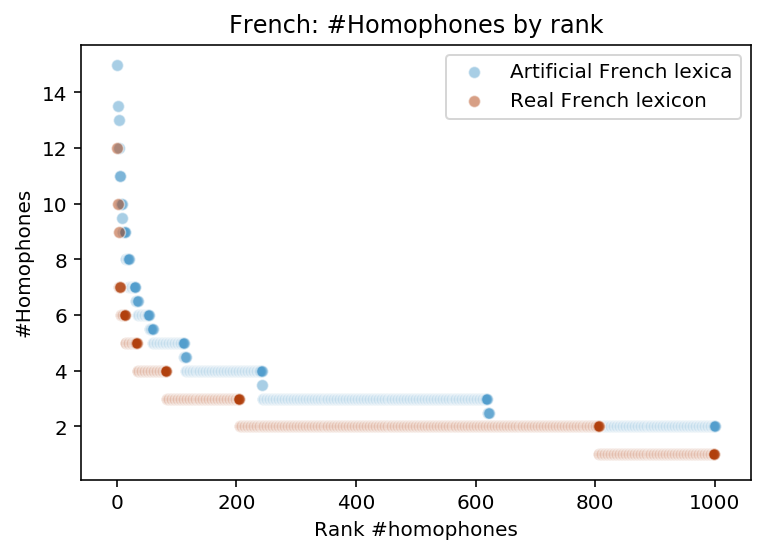

In [78]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial French lexica")

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real French lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("French: #Homophones by rank")

plt.savefig("Figures/french/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

In [79]:
rank_N = 1000

In [80]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['neighborhood_size'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'neighborhood_size': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

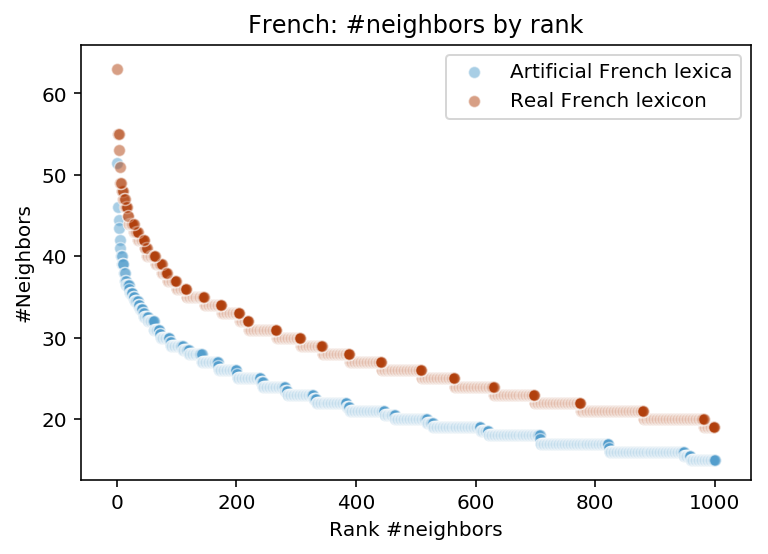

In [81]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial French lexica")

df_celex_processed['rank_num'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real French lexicon")
plt.xlabel("Rank #neighbors")
plt.ylabel("#Neighbors")
plt.title("French: #neighbors by rank")

plt.savefig("Figures/french/data_visualizations/rank_neighbors.png", dpi=300)

## Japanese

In [92]:
df_celex, df_celex_processed, df_japanese_artificials = load_lexicons_for_language("japanese", phon_column="phonetic_remapped",
                                                                                 word_column="orth_form_romaji")

In [93]:
len(df_celex)

51147

In [94]:
len(df_celex_processed)

40449

In [95]:
df_japanese_stats = get_stats_for_lexicon(df_celex_processed)
df_japanese_stats

{'homophone_percentage': 0.1506,
 'mean_homophones': 0.2645,
 'max_homophones': 33,
 'mean_mp': 4.7489,
 'max_mp': 59,
 'total_mp': 192090,
 'mean_mp_w_hp': 9.4683,
 'max_mp_w_hp': 356,
 'total_mp_w_hp': 382984}

### Preprocess artificials

In [96]:
info_for_japanese = process_and_extract_artificials(df_japanese_artificials)

100%|██████████| 10/10 [00:08<00:00,  1.27it/s]


In [97]:
processed_artificials = info_for_japanese['processed_dataframes']

In [98]:
df_celex_processed['surprisal_normed'] = df_celex_processed['surprisal'] / df_celex_processed['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Visualizations

### `#homophones` ~ `rank_homophones`

In [99]:
rank_N = 1000

In [100]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['num_homophones'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'num_homophones': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

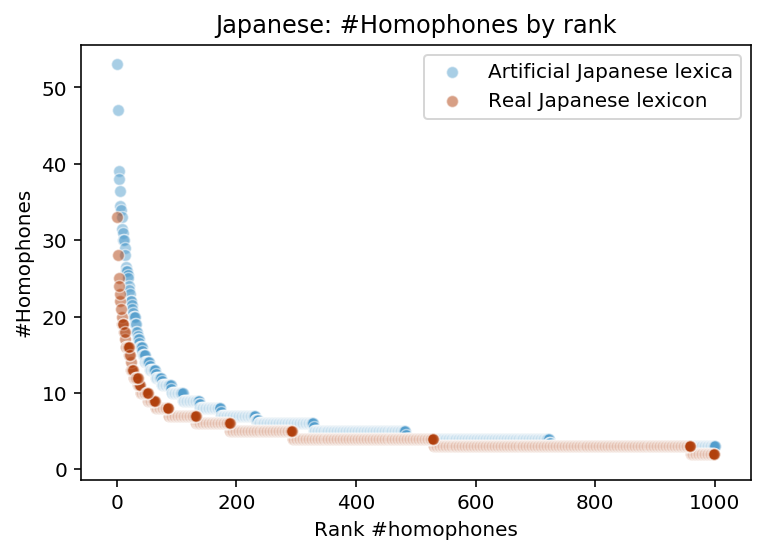

In [101]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial Japanese lexica")

df_celex_processed['rank_num'] = df_celex_processed['num_homophones'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Japanese lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("Japanese: #Homophones by rank")

plt.savefig("Figures/japanese/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

In [102]:
rank_N = 1000

In [103]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['neighborhood_size'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'neighborhood_size': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

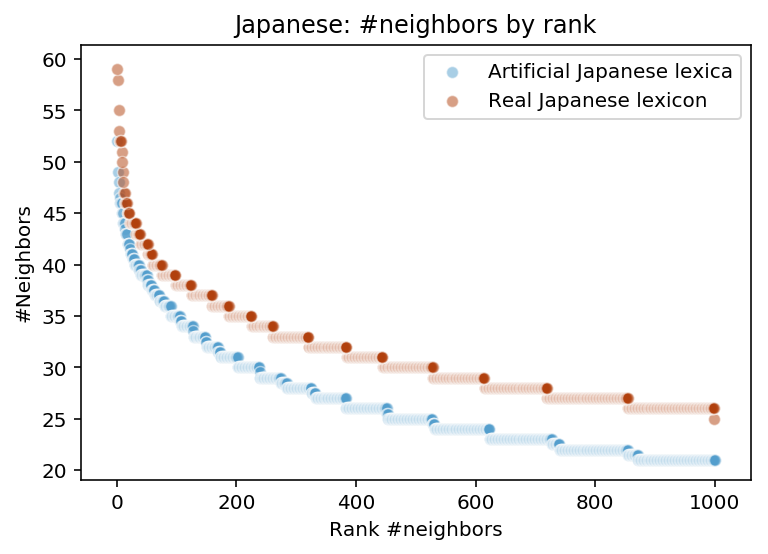

In [104]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial Japanese lexica")

df_celex_processed['rank_num'] = df_celex_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_celex_processed[df_celex_processed['rank_num']<1000],
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Japanese lexicon")
plt.xlabel("Rank #neighbors")
plt.ylabel("#Neighbors")
plt.title("Japanese: #neighbors by rank")

plt.savefig("Figures/japanese/data_visualizations/rank_neighbors.png", dpi=300)

## Mandarin

In [37]:
df_og, df_main_processed, df_mandarin_artificials = load_lexicons_for_language("mandarin", word_column="word",
                                                                              phon_column="phonetic_remapped")

Number of tokens: 92880
Number of tokens: 92880
Number of tokens: 82924


In [38]:
len(df_og)

92880

In [39]:
len(df_main_processed)

82924

In [40]:
# df_mandarin_stats = get_stats_for_lexicon(df_celex_processed)

df_mandarin_stats = utils.get_stats_for_lexicon(df_main_processed)
df_mandarin_stats

{'homophone_percentage': 0.0713,
 'mean_homophones': 0.1201,
 'max_homophones': 41,
 'mean_mp': 1.4239,
 'max_mp': 26,
 'total_mp': 118072,
 'mean_mp_w_hp': 2.2257,
 'max_mp_w_hp': 194,
 'total_mp_w_hp': 184565}

### Preprocess artificials

In [41]:
info_for_mandarin = process_and_extract_artificials(df_mandarin_artificials, remove=False)

100%|██████████| 10/10 [00:14<00:00,  1.36s/it]


In [42]:
processed_artificials = info_for_mandarin['processed_dataframes']

#### Most homophonous wordforms

In [51]:
df_main_processed.sort_values(by = "num_homophones", ascending=False).head(10)[['phonetic_remapped', 'num_sylls_est', 'num_homophones', 'neighborhood_size']]

,phonetic_remapped,num_sylls_est,num_homophones,neighborhood_size
946,y1,1,41,10
2103,i4,1,36,18
5,ʂɨ4,1,28,13
1129,Gɛn2,1,28,10
1997,tɕGɛ2,1,25,7
353,tɕGɛn4,1,24,6
1278,pi4,1,24,17
1755,ɕi1,1,23,11
988,tɕi4,1,23,10
1804,li4,1,22,19


In [53]:
processed_artificials[0].sort_values(by = "num_homophones", ascending=False).head(10)[['word', 'num_sylls_est', 'num_homophones', 'neighborhood_size']]

,word,num_sylls_est,num_homophones,neighborhood_size
2811,sɨ1 tʻə4,2,68,8
4545,a1 əɹ3,2,67,13
467,kʻə4,1,65,5
1474,mI4 kʻə4,2,52,9
1166,tɕʻi4,1,50,6
764,tɕi1,1,49,9
2212,kʻə4 sɨ1,2,45,7
661,tɕGɛ2,1,45,8
52,tɕʻi2,1,42,7
163,tɕi2,1,40,7


### `#homophones` ~ `rank_homophones`

In [16]:
rank_N = 1000

In [17]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['num_homophones'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['num_homophones'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'num_homophones': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

In [18]:
df_main_processed['rank_num'] = df_main_processed['num_homophones'].rank(ascending=False, method="first")

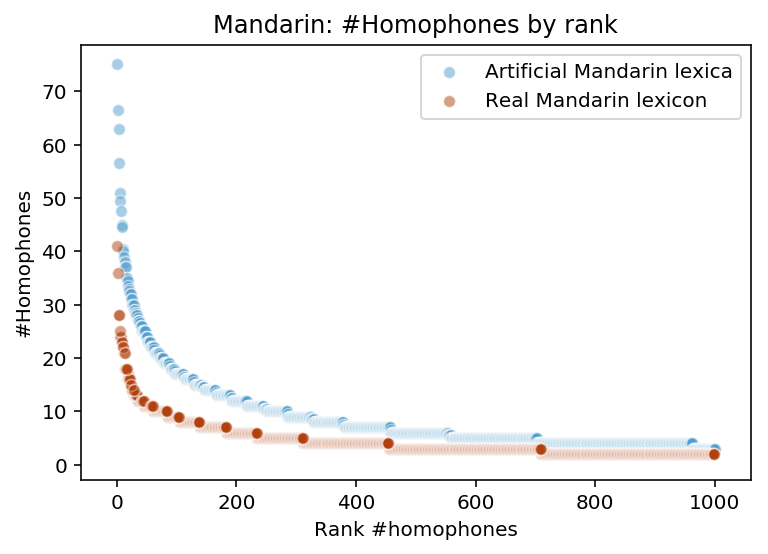

In [19]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial Mandarin lexica")

sns.scatterplot(data = df_main_processed[df_main_processed['rank_num']<rank_N],
               x = "rank_num",
               y = "num_homophones", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Mandarin lexicon")
plt.xlabel("Rank #homophones")
plt.ylabel("#Homophones")
plt.title("Mandarin: #Homophones by rank")

plt.savefig("Figures/mandarin/data_visualizations/rank_homophones.png", dpi=300)

### `#minimal pairs` ~ `rank_minimal_pairs`

In [20]:
rank_N = 1000

In [21]:
tops = []
for index, df_tmp_art in enumerate(processed_artificials):
    df_tmp_art['rank_num'] = df_tmp_art['neighborhood_size'].rank(ascending=False, method="first")
    top_n = sorted(df_tmp_art[df_tmp_art['rank_num']<=rank_N]['neighborhood_size'].values, reverse=True)
    tops.append(top_n)
stats = []
for n in range(rank_N):
    stats.append({
        'rank_num': n + 1,
        'neighborhood_size': np.median([i[n] for i in tops])
    })
df_stats = pd.DataFrame(stats)

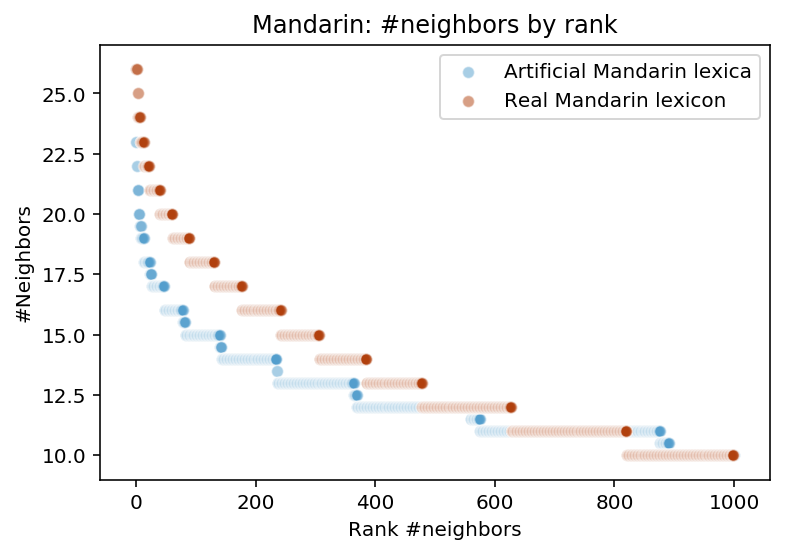

In [22]:
sns.scatterplot(data = df_stats,
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("Blues")[3],
                alpha = .5,
                label = "Artificial Mandarin lexica")

df_main_processed['rank_num'] = df_main_processed['neighborhood_size'].rank(ascending=False, method="first")
sns.scatterplot(data = df_main_processed[df_main_processed['rank_num']<rank_N],
               x = "rank_num",
               y = "neighborhood_size", 
                color = sns.color_palette("dark")[1],
                alpha = .5,
                label = "Real Mandarin lexicon")
plt.xlabel("Rank #neighbors")
plt.ylabel("#Neighbors")
plt.title("Mandarin: #neighbors by rank")

plt.savefig("Figures/mandarin/data_visualizations/rank_neighbors.png", dpi=300)

### Verifying tone contingencies

How well do the artificial lexica capture inter-tone contingencies in Mandarin?

For each set of **N-syllable** words, compare distribution of tones across real and artificial lexica.

In [23]:
from collections import Counter

import scipy.stats as ss

from src.utils import count_syllables

In [24]:
def has_correct_tones(wordform):
    """Check whether wordform has correct placement of tones for Mandarin."""
    sylls = wordform.split()

    # First check that each syllable ends in appropriate tone
    tones = [j[-1] for j in sylls]
    for tone in tones:
        if tone not in ['0','1', '2', '3', '4']:
            return False

    # Now check that there are no tone characters in the middle of any syllable
    for syll in sylls:
        for i in range(len(syll)):
            if i < (len(syll) - 1) and syll[i] in ['0','1', '2', '3', '4']:
                return False

    return True

def is_wellformed(wordform, vowels, language="mandarin"):
    """Check whether each Mandarin syllable has at least 1 vowel, and no more."""
    for syll in wordform.split():
        if count_syllables(syll, language="mandarin", vowels=vowels) != 1:
            return False
    return True

In [25]:
def extract_tones(wordform):
    """Get tones from each syllable."""
    return ' '.join([i[-1] for i in wordform.split()])

In [26]:
df_og['correct_tones'] = df_og['phonetic_remapped'].apply(lambda x: has_correct_tones(x))
df_og['correct_tones'].mean()

1.0

In [27]:
df_og['wellformed'] = df_og['phonetic_remapped'].apply(lambda x: is_wellformed(x, vowels=config.VOWEL_SETS['mandarin']))
df_og['wellformed'].mean()


1.0

In [28]:
df_mandarin_artificials['correct_tones'] = df_mandarin_artificials['word'].apply(lambda x: has_correct_tones(x))


In [30]:
df_mandarin_artificials['correct_tones'].mean()

1.0

In [32]:
df_mandarin_artificials['wellformed'] = df_mandarin_artificials['word'].apply(lambda x: is_wellformed(x, vowels=config.VOWEL_SETS['mandarin']))


In [33]:
df_mandarin_artificials['wellformed'].mean()

1.0

In [34]:
new = df_mandarin_artificials[(df_mandarin_artificials['correct_tones']==True)&(df_mandarin_artificials['wellformed']==True)]

In [35]:
len(df_mandarin_artificials)

928800

In [36]:
len(new)

928800

In [37]:
df_mandarin_artificials = new

In [38]:
df_mandarin_artificials['tones'] = df_mandarin_artificials['word'].apply(lambda x: extract_tones(x))
df_og['tones'] = df_og['phonetic_remapped'].apply(lambda x: extract_tones(x))

In [39]:
df_mandarin_artificials['num_tones'] = df_mandarin_artificials['tones'].apply(lambda x: len(x.split()))
df_og['num_tones'] = df_og['tones'].apply(lambda x: len(x.split()))

In [40]:
df_mandarin_artificials['right_number'] = df_mandarin_artificials['num_tones'] == df_mandarin_artificials['num_sylls_est']
df_og['right_number'] = df_og['num_tones'] == df_og['num_sylls_est']



In [41]:
dists = []
for syll_length in range(max(df_og['num_sylls_est'])):
    df_tmp = df_og[df_og['num_sylls_est']==syll_length]
    counts = Counter(df_tmp['tones'])
    for key, value in counts.items():
        dists.append({
            'real': 'Yes',
            'l': 'real',
            'num_sylls': syll_length,
            'tone_sequence': key,
            'N': value
        })

In [42]:
for lexicon in range(NUM_ARTIFICIAL):
    df_lex = df_mandarin_artificials[df_mandarin_artificials['lexicon']==lexicon]
    for syll_length in range(max(df_lex['num_sylls_est'])):
        df_tmp = df_lex[df_lex['num_sylls_est']==syll_length]
        counts = Counter(df_tmp['tones'])
        for key, value in counts.items():
            dists.append({
                'real': 'No',
                'l': lexicon,
                'num_sylls': syll_length,
                'tone_sequence': key,
                'N': value
            })

In [43]:
df_tones = pd.DataFrame(dists)

In [44]:
df_tones = df_tones.sort_values(by = "tone_sequence")

In [49]:
for lexicon in range(NUM_ARTIFICIAL):
    df_mono = df_tones[df_tones['num_sylls'] == 1]
    df_real = df_mono[df_mono['real']=="Yes"]
    df_arts = df_mono[df_mono['l']==lexicon]
    
    df_real = df_real.sort_values(by = 'tone_sequence')
    df_arts = df_arts.sort_values(by = 'tone_sequence')
    
    real_values = df_real['N'].values
    art_values = df_arts['N'].values
    
    diffs = real_values - art_values
    # print(diffs)
    
    ch_test = ss.chisquare(real_values, art_values)
    print(ch_test)
    

Power_divergenceResult(statistic=28.215447280358624, pvalue=1.1279568933046707e-05)
Power_divergenceResult(statistic=3.980861767173601, pvalue=0.4086021240124431)
Power_divergenceResult(statistic=16.4313606399881, pvalue=0.002491740282128975)
Power_divergenceResult(statistic=7.208156987783463, pvalue=0.1252885309346851)
Power_divergenceResult(statistic=15.846619910268267, pvalue=0.0032320359793237977)
Power_divergenceResult(statistic=27.2897113583979, pvalue=1.7369989997156342e-05)
Power_divergenceResult(statistic=3.309501384427395, pvalue=0.5074282572080007)
Power_divergenceResult(statistic=51.72567410160966, pvalue=1.5742165001591022e-10)
Power_divergenceResult(statistic=24.37545379712352, pvalue=6.715949253152717e-05)
Power_divergenceResult(statistic=6.423960646092759, pvalue=0.16964497628405675)


In [46]:
df_tones['tone1'] = df_tones['tone_sequence'].apply(lambda x: x[0])

In [47]:
df_tones2 = df_tones[df_tones['num_sylls']==2]
df_tones3 = df_tones[df_tones['num_sylls']==3]

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


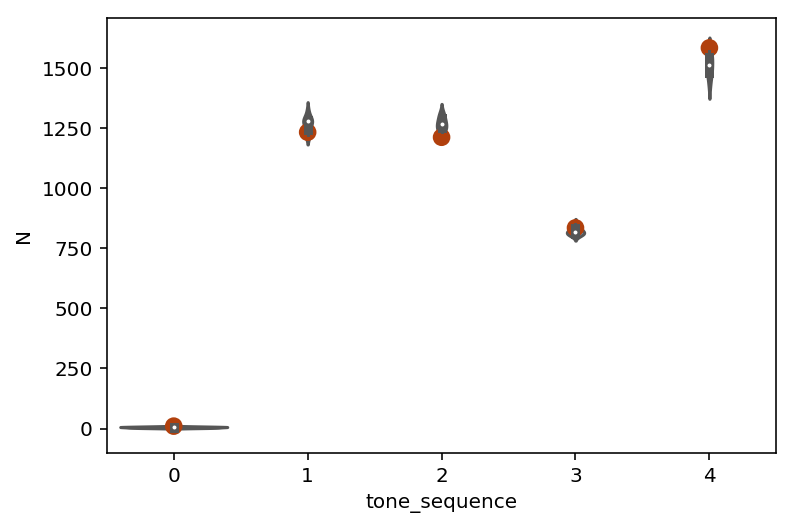

In [48]:
sns.violinplot(data = df_tones[(df_tones['num_sylls']==1)&(df_tones['real']=="No")],
              x = 'tone_sequence',
               color = sns.color_palette("Blues")[3],
               order = ['0', '1', '2', '3', '4'],
              y = 'N')

sns.pointplot(data = df_tones[(df_tones['num_sylls']==1)&(df_tones['real']=="Yes")],
              x = 'tone_sequence',
              join=False,
              order = ['0', '1', '2', '3', '4'],
                color = sns.color_palette("dark")[1],
              y = 'N')

plt.savefig("Figures/mandarin/tones/mono.png", dpi=300)

In [56]:
df_tones2['tone_sequence'] = df_tones2['tone_sequence'].apply(lambda x: x.replace(" ", ""))

/Users/seantrott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


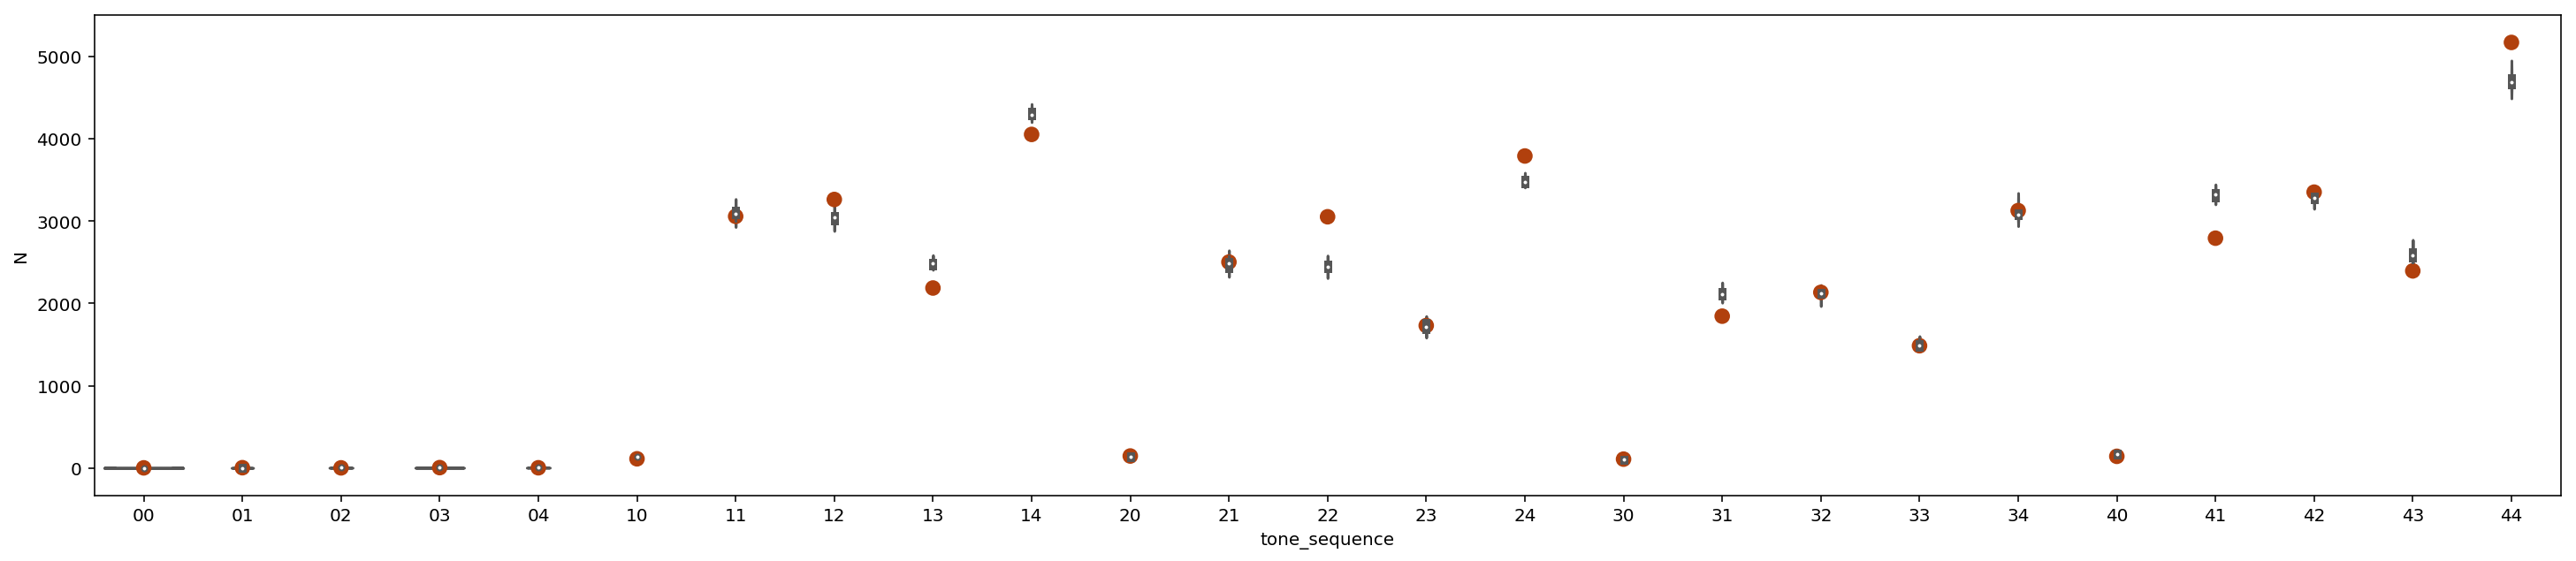

In [57]:
plt.figure(figsize=(25,5))

sns.violinplot(data = df_tones2[df_tones2['real']=="No"],
               x = 'tone_sequence',
               y = 'N',
               # order = ['4 0','4 1','4 2', '4 3', '4 4'],
               color = sns.color_palette("Blues")[3])

sns.pointplot(data = df_tones2[df_tones2['real']=="Yes"],
                x = 'tone_sequence',
                y = 'N',
              join = False,
                # order = ['4 0','4 1','4 2', '4 3', '4 4'],
                color = sns.color_palette("dark")[1])

plt.savefig("Figures/mandarin/tones/di_tones.png", dpi=300)

In [58]:
df_tones3['tone_sequence'] = df_tones3['tone_sequence'].apply(lambda x: x.replace(" ", ""))

/Users/seantrott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


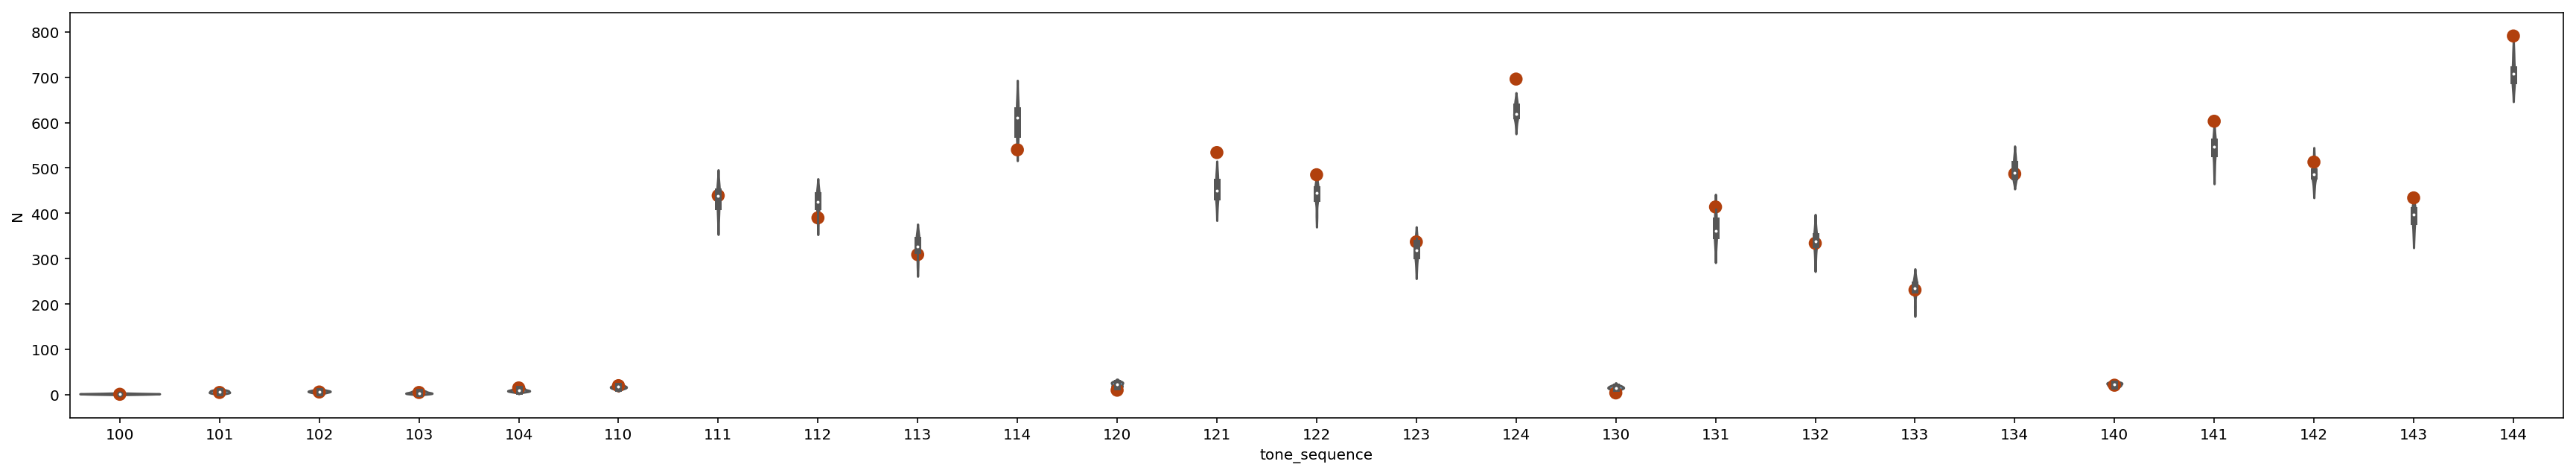

In [59]:
plt.figure(figsize=(30,5))
sns.violinplot(data = df_tones3[(df_tones3['real']=="No")&(df_tones3['tone1']=="1")],
               x = 'tone_sequence',
               y = 'N',
               # order = ['4 0','4 1','4 2', '4 3', '4 4'],
               color = sns.color_palette("Blues")[3])

sns.pointplot(data = df_tones3[(df_tones3['real']=="Yes")&(df_tones3['tone1']=="1")],
                x = 'tone_sequence',
                y = 'N',
              join = False,
                # order = ['4 0','4 1','4 2', '4 3', '4 4'],
                color = sns.color_palette("dark")[1])

plt.savefig("Figures/mandarin/tones/tri_tones_1.png", dpi=300)

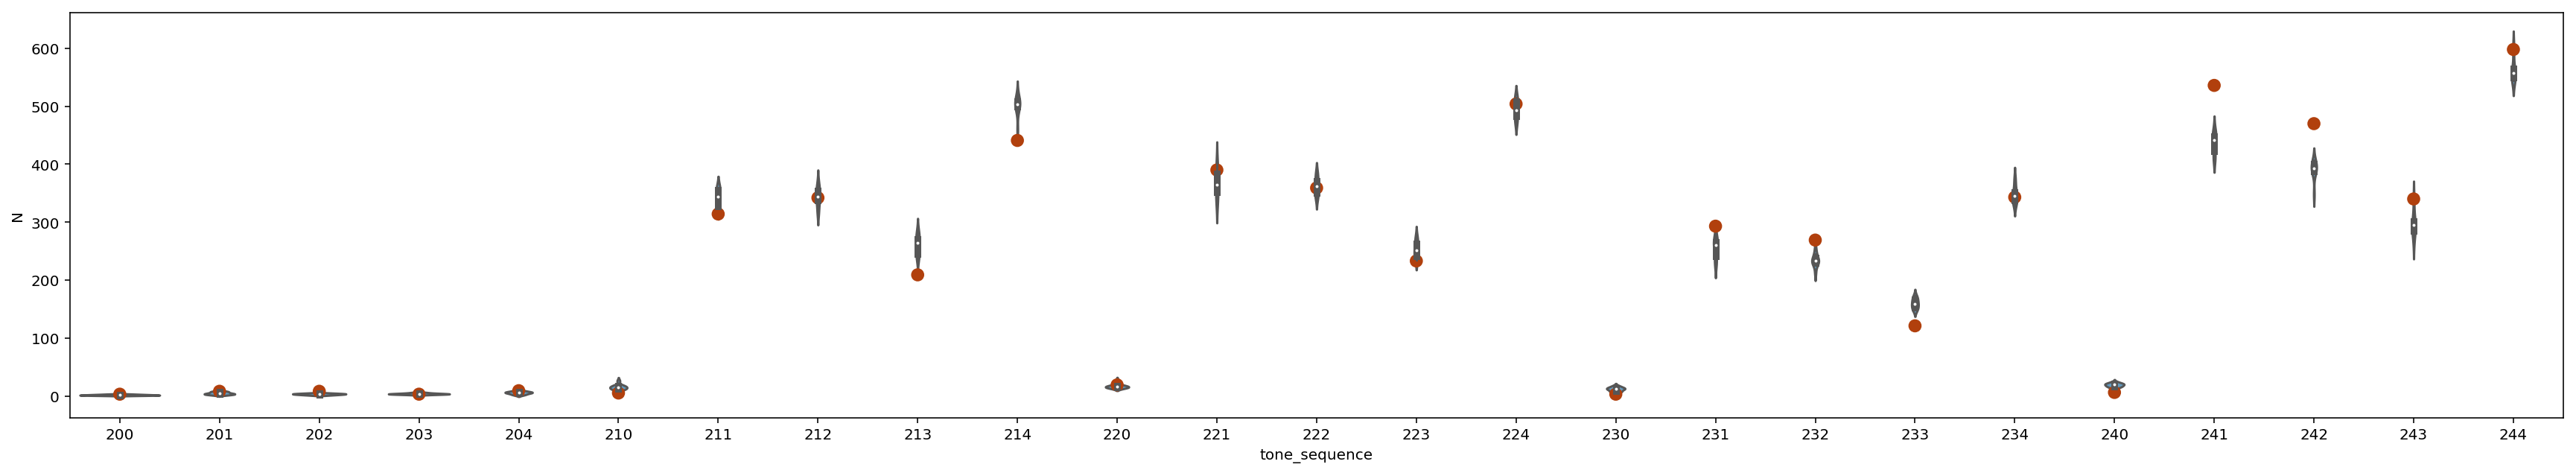

In [60]:
plt.figure(figsize=(30,5))
sns.violinplot(data = df_tones3[(df_tones3['real']=="No")&(df_tones3['tone1']=="2")],
               x = 'tone_sequence',
               y = 'N',
               # order = ['4 0','4 1','4 2', '4 3', '4 4'],
               color = sns.color_palette("Blues")[3])

sns.pointplot(data = df_tones3[(df_tones3['real']=="Yes")&(df_tones3['tone1']=="2")],
                x = 'tone_sequence',
                y = 'N',
              join = False,
                # order = ['4 0','4 1','4 2', '4 3', '4 4'],
                color = sns.color_palette("dark")[1])


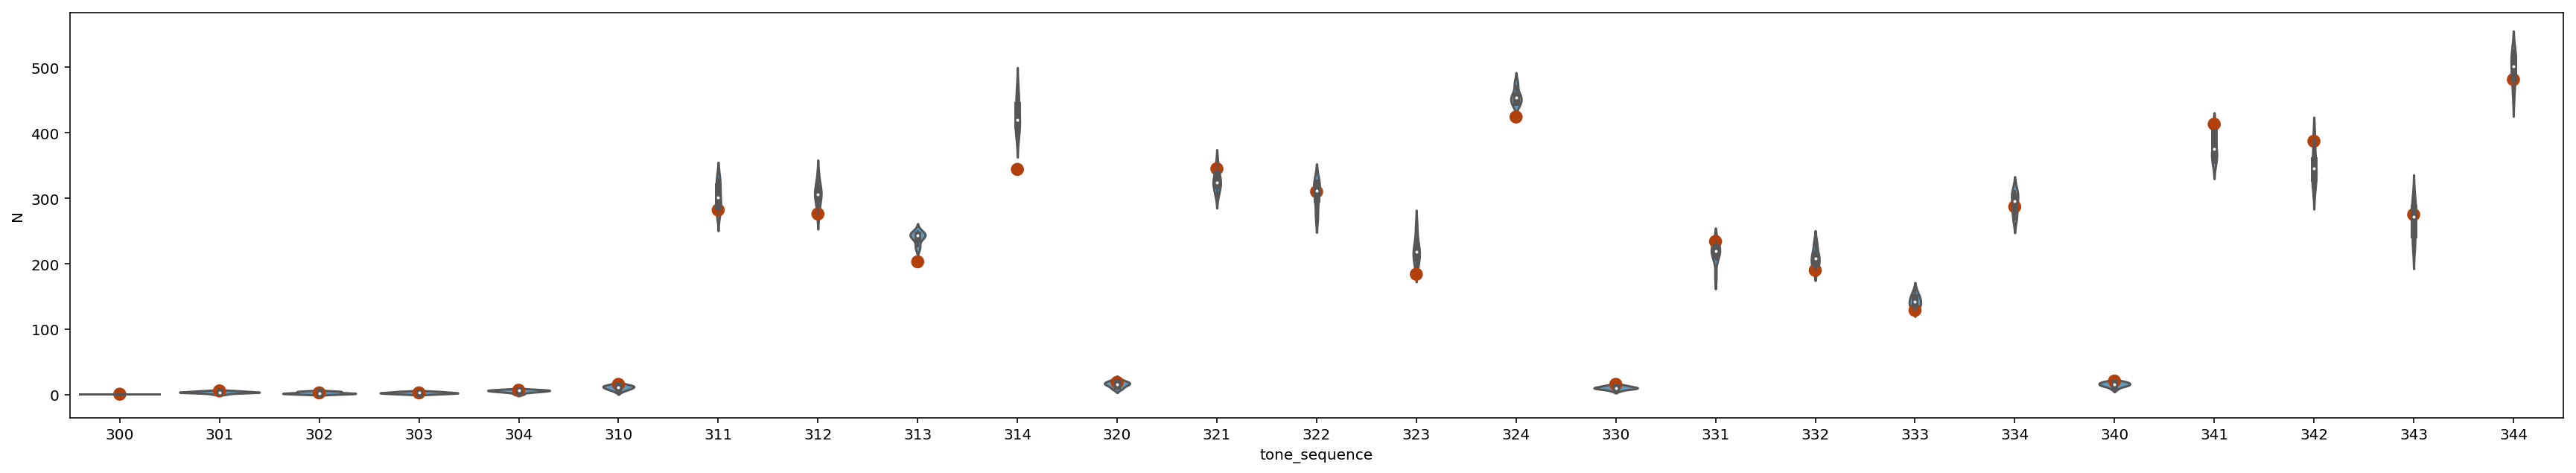

In [61]:
plt.figure(figsize=(30,5))
sns.violinplot(data = df_tones3[(df_tones3['real']=="No")&(df_tones3['tone1']=="3")],
               x = 'tone_sequence',
               y = 'N',
               # order = ['4 0','4 1','4 2', '4 3', '4 4'],
               color = sns.color_palette("Blues")[3])

sns.pointplot(data = df_tones3[(df_tones3['real']=="Yes")&(df_tones3['tone1']=="3")],
                x = 'tone_sequence',
                y = 'N',
              join = False,
                # order = ['4 0','4 1','4 2', '4 3', '4 4'],
                color = sns.color_palette("dark")[1])


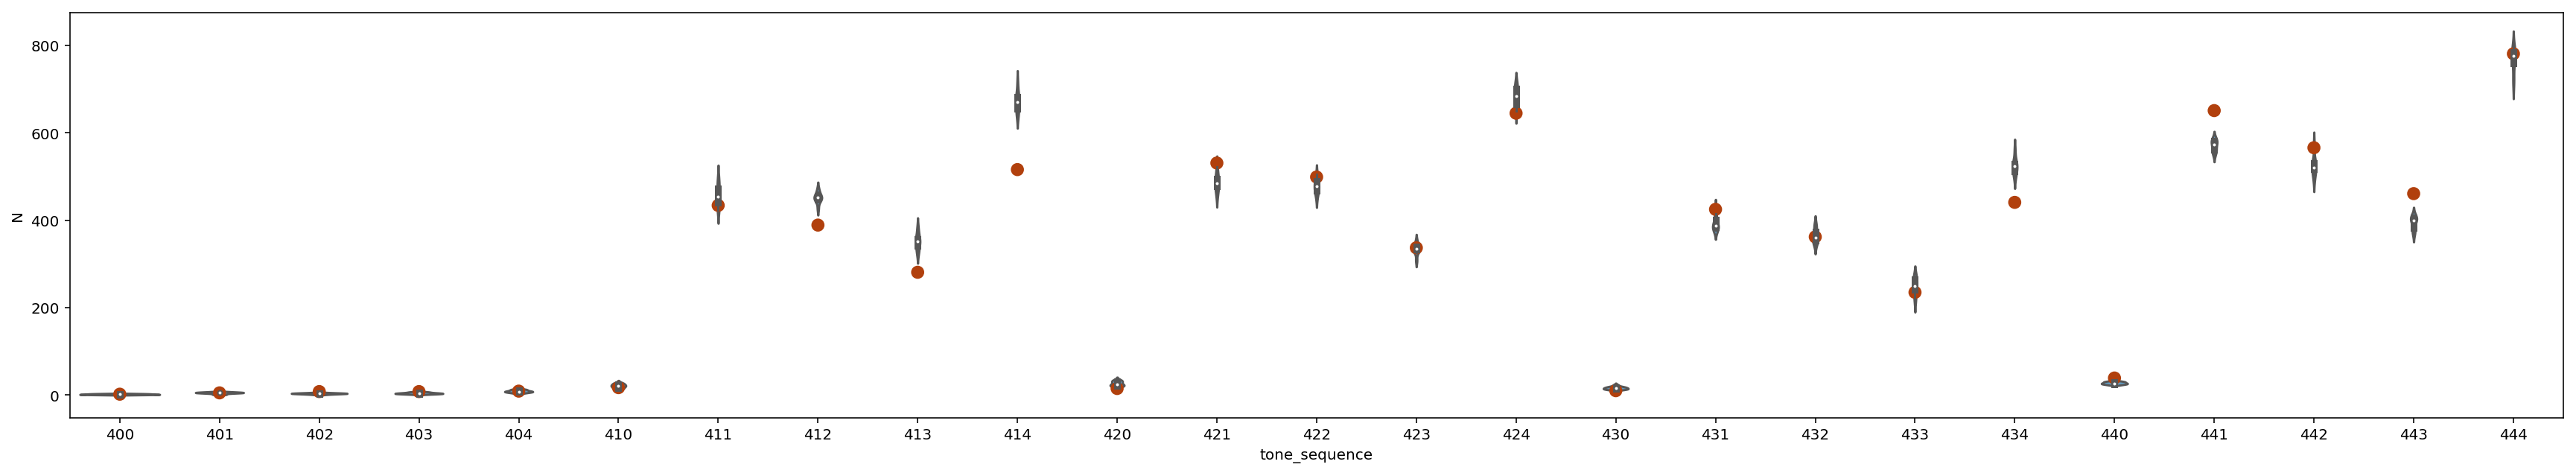

In [62]:
plt.figure(figsize=(30,5))
sns.violinplot(data = df_tones3[(df_tones3['real']=="No")&(df_tones3['tone1']=="4")],
               x = 'tone_sequence',
               y = 'N',
               # order = ['4 0','4 1','4 2', '4 3', '4 4'],
               color = sns.color_palette("Blues")[3])

sns.pointplot(data = df_tones3[(df_tones3['real']=="Yes")&(df_tones3['tone1']=="4")],
                x = 'tone_sequence',
                y = 'N',
              join = False,
                # order = ['4 0','4 1','4 2', '4 3', '4 4'],
                color = sns.color_palette("dark")[1])


# Concatenating all languages together

For convenience, the code below runs the primary analyses on each language to build a summary table of the main findings.

In [9]:
languages = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin']

In [10]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))


# Predicting minimal pairs
TARGET_MODEL_3 = 'neighborhood_size'
COVARIATES_MODEL_3 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_3 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_3, regressors=' + '.join(COVARIATES_MODEL_3))


In [11]:
#Supplementary models: non-normed surprisal
TARGET_MODEL_4 = 'num_homophones'
COVARIATES_MODEL_4 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_4 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_4, regressors=' + '.join(COVARIATES_MODEL_4))


In [12]:
model1_results, model2_results, model3_results = [], [], []
model4_results, model5_results, model6_results = [], [], []
descriptive_stats = []

for language in languages:
    print(language)
    phon_column = config.PHON_COLUMN[language]
    word_column = config.WORD_COLUMN[language]
    df_og, df_processed, df_artificials = load_lexicons_for_language(language, phon_column=phon_column,
                                                                     word_column=word_column)

    # Process artificial lexica
    if language == "mandarin":
        language_info = process_and_extract_artificials(df_artificials, remove=False)
    else:
        language_info = process_and_extract_artificials(df_artificials, remove=True)
    processed_artificials = language_info.pop('processed_dataframes')
    
    # Create normed surprisal column
    df_processed['surprisal_normed'] = df_processed['surprisal'] / df_processed['num_phones']
    for p in processed_artificials:
        p['surprisal_normed'] = p['surprisal'] / p['num_phones']
        
    ####### Get descriptive statistics #######
    stats_real = get_stats_for_lexicon(df_processed)
    stats_real['language'] = language
    stats_real['real'] = "Yes"
    descriptive_stats.append(pd.DataFrame([stats_real]))
    
    # Add descriptive statistics from artificial lexica
    simulated_stats = pd.DataFrame(language_info)
    simulated_stats['language'] = [language for i in range(len(simulated_stats))]
    simulated_stats['real'] = ["No" for i in range(len(simulated_stats))]
    descriptive_stats.append(simulated_stats)
    
    ####### Statistical modeling #######
    
    # Run model 1
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_1, 
                                covariates=COVARIATES_MODEL_1)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 1 data
    model1_results.append(df_analysis)

    # Run model 3
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_3, 
                                covariates=COVARIATES_MODEL_3)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 3 data
    model3_results.append(df_analysis)
    
    ##### Supplementary (non-normalized surprisal)
    
    # Run model 4
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_4, 
                                covariates=COVARIATES_MODEL_4)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 4 data
    model4_results.append(df_analysis)


english
Number of tokens: 52437
Number of tokens: 41887


/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


Number of tokens: 35107


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


german
Number of tokens: 51718
Number of tokens: 51718
Number of tokens: 50474


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


dutch
Number of tokens: 67910
Number of tokens: 67583
Number of tokens: 65351


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


french
Number of tokens: 47309
Number of tokens: 43782
Number of tokens: 37278


100%|██████████| 10/10 [00:07<00:00,  1.48it/s]


japanese
Number of tokens: 51147
Number of tokens: 51147
Number of tokens: 40449


100%|██████████| 10/10 [00:07<00:00,  1.44it/s]


mandarin
Number of tokens: 92880
Number of tokens: 92880
Number of tokens: 82924


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


## Descriptive results

### Homophony

In [13]:
df_descriptive = pd.concat(descriptive_stats)
df_descriptive.to_csv("desc.csv")

/Users/seantrott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


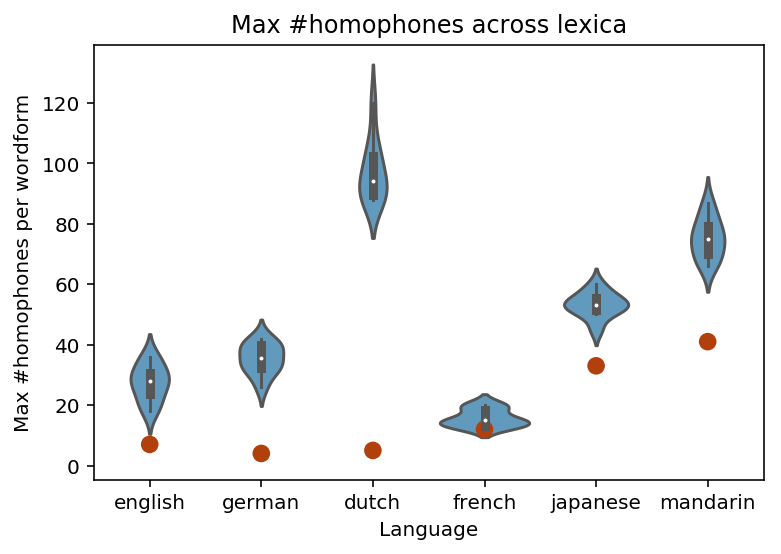

In [17]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'max_homophones',
           # palette = 'Blues',
            color = sns.color_palette("Blues")[3],
               order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
               label = "Simulated"
            # hue = "real"
           )

sns.pointplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'max_homophones',
           color = sns.color_palette("dark")[1],
                label = "Real lexica",
              order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
              size = .5,
              join = False
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
    
plt.title("Max #homophones across lexica")
plt.ylabel("Max #homophones per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/max_homophones_with_mandarin.png", dpi=400, bbox_inches = "tight")

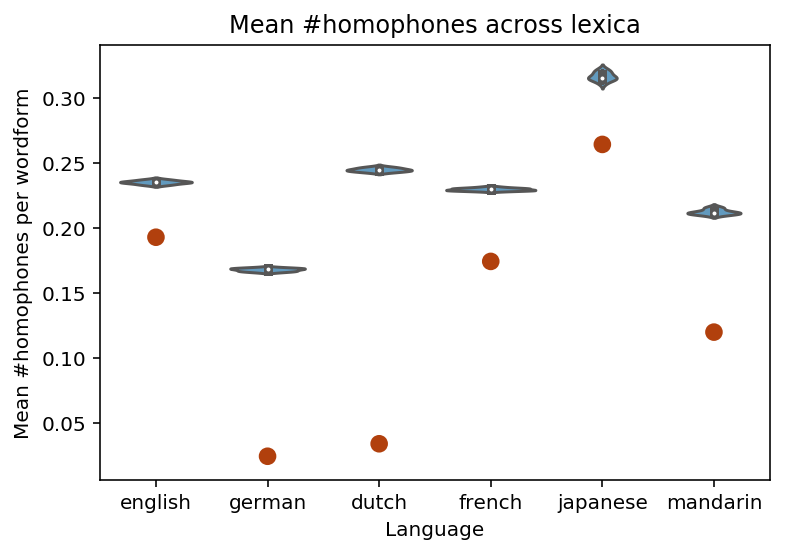

In [18]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'mean_homophones',
           # palette = 'Blues',
            color = sns.color_palette("Blues")[3],
               order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
            # hue = "real"
           )

sns.pointplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'mean_homophones',
           color = sns.color_palette("dark")[1],
                label = "Real lexica",
              order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
              size = .5,
              join = False
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
    
plt.title("Mean #homophones across lexica")
plt.ylabel("Mean #homophones per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/mean_homophones_with_mandarin.png", dpi=400, bbox_inches = "tight")

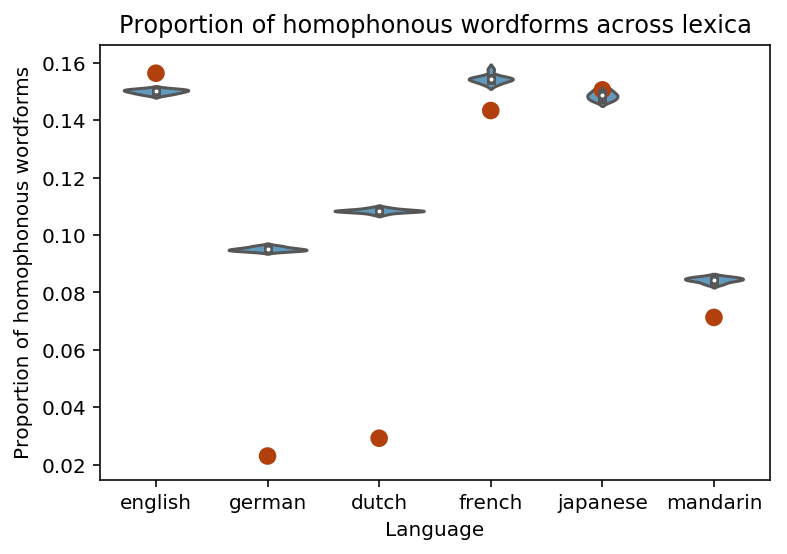

In [19]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'homophone_percentage',
           color = sns.color_palette("Blues")[3],
               order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
            # hue = "real"
           )

sns.pointplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'homophone_percentage',
           color = sns.color_palette("dark")[1],
                label = "Real lexica",
              order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
              size = .5,
              join = False
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Proportion of homophonous wordforms across lexica")
plt.ylabel("Proportion of homophonous wordforms")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/homophony_rate_with_mandarin.png", dpi=400, bbox_inches = "tight")

### Minimal pairs

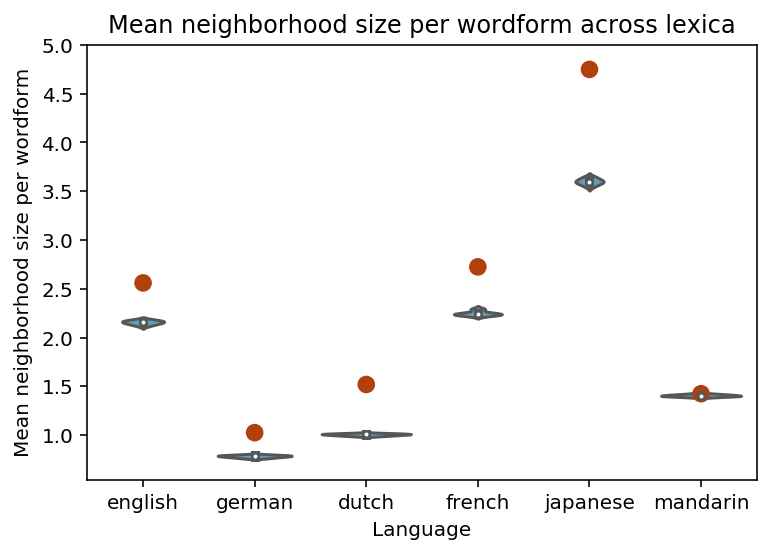

In [21]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'mean_mp',
           color = sns.color_palette("Blues")[3],
               order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
            # hue = "real"
           )

sns.pointplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'mean_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica",
              order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
              join = False
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Mean neighborhood size per wordform across lexica")
plt.ylabel("Mean neighborhood size per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/mean_mps_with_mandarin.png", dpi=400, bbox_inches = "tight")

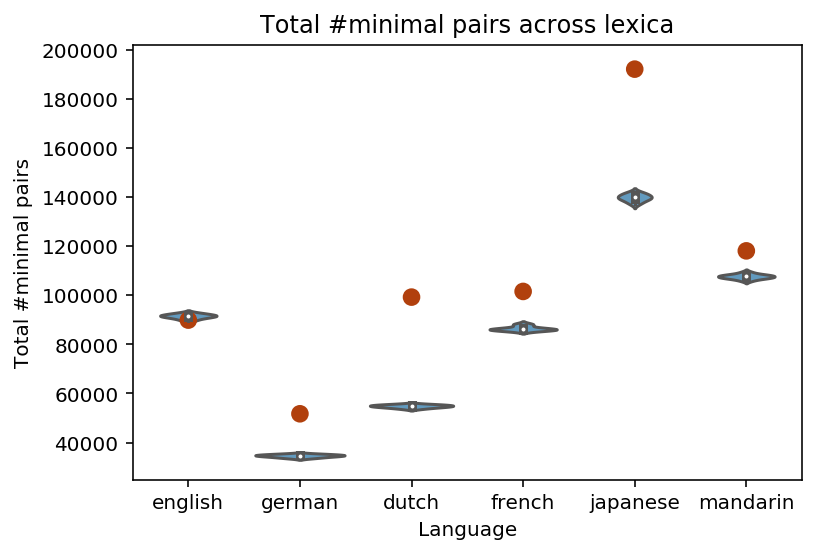

In [22]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'total_mp',
           color = sns.color_palette("Blues")[3],
               order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
            # hue = "real"
           )

sns.pointplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'total_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica",
              order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
              join = False
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Total #minimal pairs across lexica")
plt.ylabel("Total #minimal pairs")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/total_mps.png", dpi=400, bbox_inches = "tight")

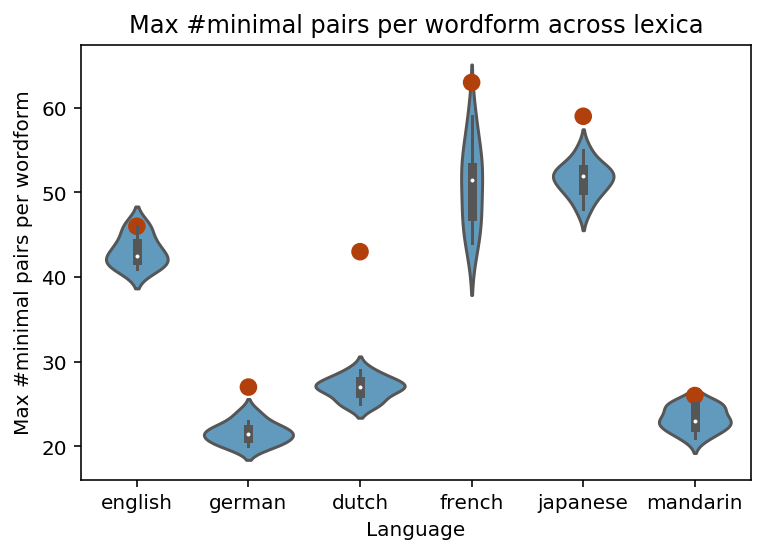

In [23]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'max_mp',
           color = sns.color_palette("Blues")[3],
               order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
            # hue = "real"
           )

sns.pointplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'max_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica",
              order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
              join = False
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Max #minimal pairs per wordform across lexica")
plt.ylabel("Max #minimal pairs per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/max_mps.png", dpi=400, bbox_inches = "tight")

## Modeling results

### Model 1: `#homophones ~ #syllables + surprisal`

In [24]:
df_all_model1 = pd.concat(model1_results)

In [25]:
df_all_model1.to_csv("m1.csv")

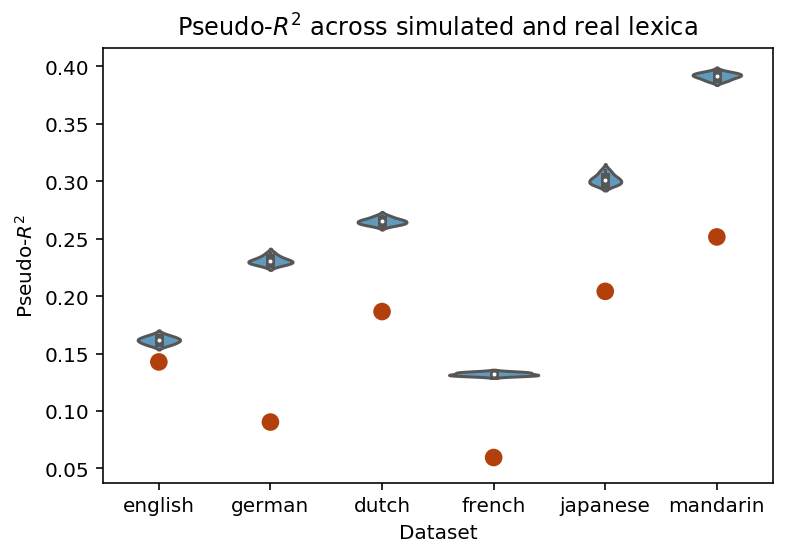

In [27]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
            # hue = "real"
           )

sns.pointplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
              join = False,
                order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )

plt.title("Pseudo-$R^2$ across simulated and real lexica")
plt.ylabel("Pseudo-$R^2$")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_r2_with_mandarin.png", dpi=400, bbox_inches = "tight")

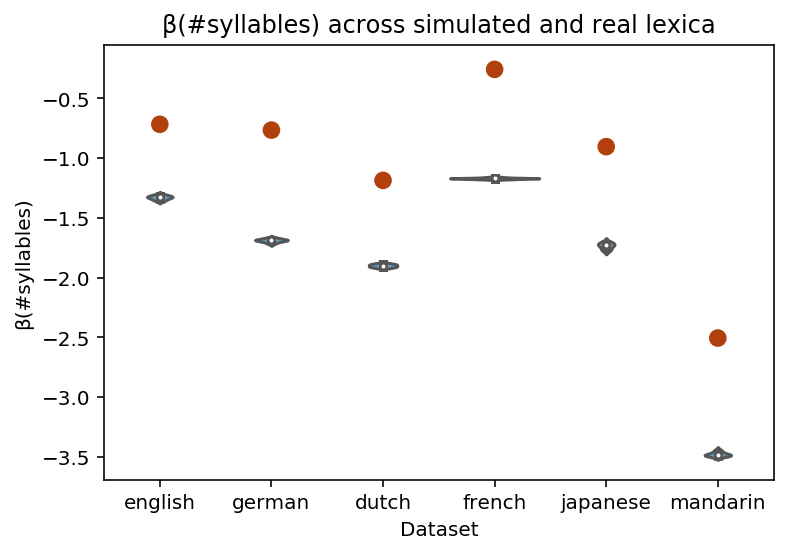

In [29]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'num_sylls_est',
            color = sns.color_palette("Blues")[3],
               order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
            # hue = "real"
           )

sns.pointplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'num_sylls_est',
           color = sns.color_palette("dark")[1],
              join = False,
                order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#syllables) across simulated and real lexica")
plt.ylabel("\u03B2(#syllables)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_#sylls_with_mandarin.png", dpi=400, bbox_inches = "tight")

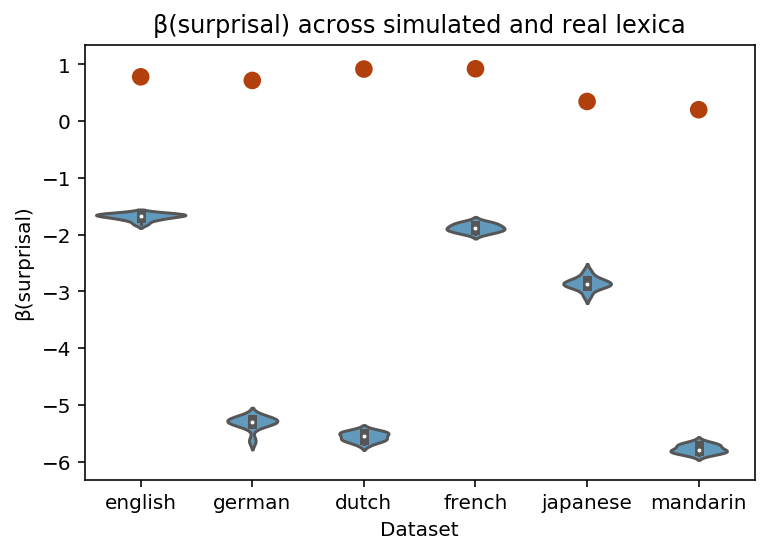

In [30]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'surprisal_normed',
            color = sns.color_palette("Blues")[3],
               order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
            # hue = "real"
           )

sns.pointplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'surprisal_normed',
           color = sns.color_palette("dark")[1],
                label = "Real lexica",
                  join = False,
                order = ['english', 'german', 'dutch', 'french', 'japanese', 'mandarin'],
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(surprisal) across simulated and real lexica")
plt.ylabel("\u03B2(surprisal)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_surprisal_with_mandarin.png", dpi=400, bbox_inches = "tight")

### Model 2: `#minimal pairs ~ #syllables + surprisal`

In [31]:
df_all_model3 = pd.concat(model3_results)

Text(0.5, 0, 'Dataset')

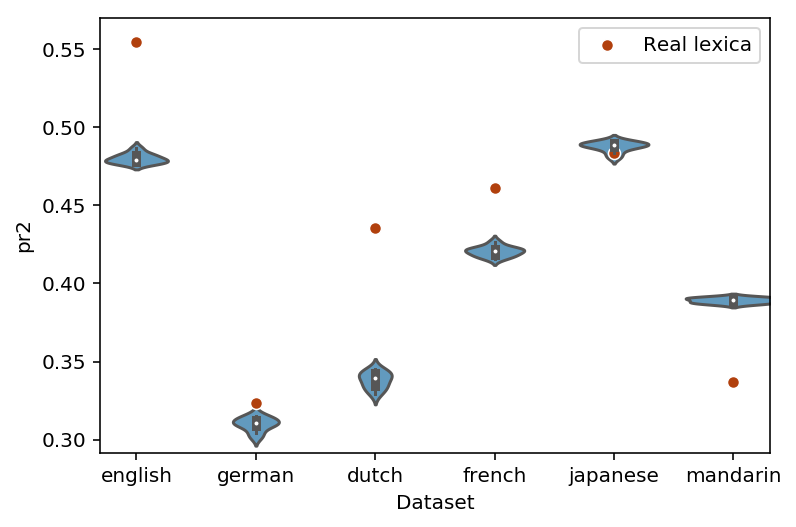

In [32]:
sns.violinplot(data = df_all_model3[df_all_model3['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model3[df_all_model3['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
# plt.title("\u03B2(#minimal pairs) across simulated and real lexica")
# plt.ylabel("\u03B2(#minimal pairs)")
plt.xlabel("Dataset")
# plt.savefig("Figures/combined/modeling/model2_mps.png", dpi=400, bbox_inches = "tight")

## Supplementary models

### Model 3: `#homophones ~ #syllables + surprisal`

In [33]:
df_all_model4 = pd.concat(model4_results)

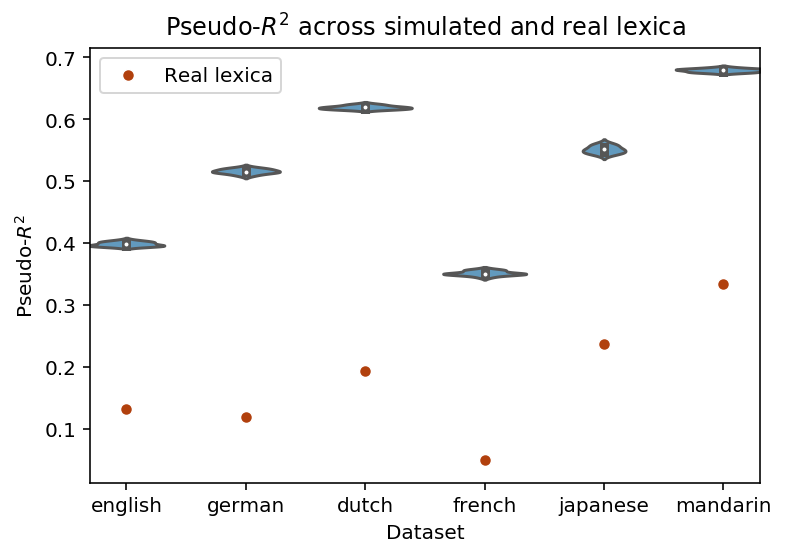

In [34]:
sns.violinplot(data = df_all_model4[df_all_model4['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model4[df_all_model4['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )

plt.title("Pseudo-$R^2$ across simulated and real lexica")
plt.ylabel("Pseudo-$R^2$")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model4_r2_with_mandarin.png", dpi=400, bbox_inches = "tight")

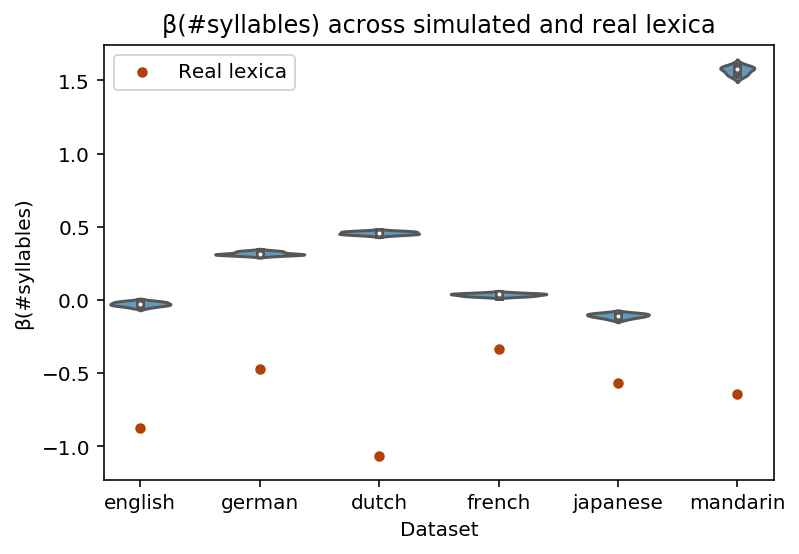

In [35]:
sns.violinplot(data = df_all_model4[df_all_model4['real']=="No"],
           x = "language",
           y = 'num_sylls_est',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model4[df_all_model4['real']=="Yes"],
           x = "language",
           y = 'num_sylls_est',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#syllables) across simulated and real lexica")
plt.ylabel("\u03B2(#syllables)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model4_#sylls_with_mandarin.png", dpi=400, bbox_inches = "tight")

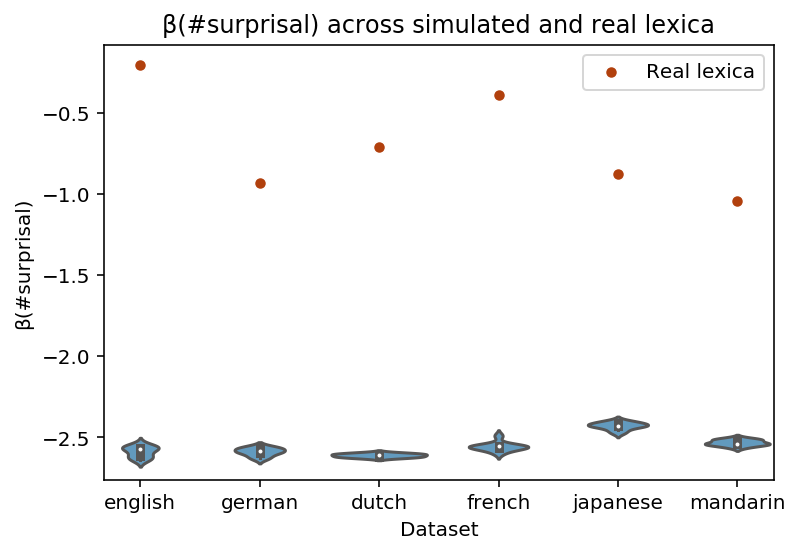

In [36]:
sns.violinplot(data = df_all_model4[df_all_model4['real']=="No"],
           x = "language",
           y = 'surprisal',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model4[df_all_model4['real']=="Yes"],
           x = "language",
           y = 'surprisal',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#surprisal) across simulated and real lexica")
plt.ylabel("\u03B2(#surprisal)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model4_surprisal_with_mandarin.png", dpi=400, bbox_inches = "tight")

# Supplementary analyses: biphone model

## English

In [18]:
df_real = pd.read_csv("data/processed/english/english_all_reals_2phone.csv")
df_lemmas = pd.read_csv("data/processed/english/english_lemmas_processed_2phone.csv")
df_artificials = pd.read_csv("data/processed/english/english_artificial_10_matched_on_sylls_no_restriction_2phone.csv")


In [48]:
english_stats = utils.get_homophone_stats(df_lemmas)

### Preprocess artificials

In [25]:
def process_and_extract_artificials(df_artificials, N=10):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                          phon_column="word", word_column="word")
        
        lex_stats = utils.get_homophone_stats(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentage': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones
           }
    

In [26]:
info_for_english = process_and_extract_artificials(df_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


In [27]:
processed_artificials = info_for_english['processed_dataframes']

#### Norm surprisal

In [29]:
df_lemmas['surprisal_normed'] = df_lemmas['surprisal'] / df_lemmas['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Descriptive

In [61]:
max_m = round(np.mean(info_for_english['max_homophones']), 2)
max_std = round(np.std(info_for_english['max_homophones']), 3)
print("Max homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = max_m, max_std=max_std))
print("Real: {m}".format(m = english_stats['max_homophones']))

Max homophony: 
Artificial: M = 434.3, SD = 26.272
Real: 7


In [60]:
mean_m = round(np.mean(info_for_english['mean_homophones']), 2)
mean_std = round(np.std(info_for_english['mean_homophones']), 3)
print("Mean homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = mean_m, max_std=mean_std))
print("Real: {m}".format(m = english_stats['mean_homophones']))

Mean homophony: 
Artificial: M = 0.13, SD = 0.001
Real: 0.1931


In [64]:
prop_m = round(np.mean(info_for_english['homophone_percentage']), 2)
prop_std = round(np.std(info_for_english['homophone_percentage']), 4)
print("Proportion of homophonous wordforms: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = prop_m, max_std=prop_std))
print("Real: {m}".format(m = english_stats['homophone_percentage']))

Proportion of homophonous wordforms: 
Artificial: M = 0.04, SD = 0.0004
Real: 0.1564


## Modeling

### `num_homophones ~ #sylls + surprisal_normalized`

In [66]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [67]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['english' for i in range(len(df_analysis))]

In [77]:
df_analysis[df_analysis['real']=="No"].describe()

,Intercept,surprisal_normed,num_sylls_est,pr2
count,10.000000,10.000000,10.000000,10.000000
mean,4.230504,-1.050552,-2.542480,0.304853
std,0.148390,0.108901,0.031269,0.003768
min,4.018361,-1.160712,-2.576906,0.298530
25%,4.107485,-1.133286,-2.566606,0.302814
50%,4.239478,-1.103975,-2.550849,0.305901
75%,4.365461,-0.939193,-2.525528,0.307710
max,4.404717,-0.898959,-2.490742,0.309721


In [73]:
df_analysis[df_analysis['real']=="Yes"]

,Intercept,surprisal_normed,num_sylls_est,real,pr2,language
0,0.264016,0.104042,-0.944182,Yes,0.130236,english


### `num_homophones ~ #sylls + surprisal`

In [78]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [79]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['english' for i in range(len(df_analysis))]

In [80]:
df_analysis[df_analysis['real']=="No"].describe()

,Intercept,surprisal,num_sylls_est,pr2
count,10.000000,10.000000,10.000000,10.000000
mean,9.612628,-2.536192,1.284275,0.807300
std,0.047587,0.012269,0.026304,0.003401
min,9.549179,-2.555012,1.249678,0.802227
25%,9.589964,-2.546320,1.269048,0.805174
50%,9.602853,-2.533906,1.281203,0.807062
75%,9.643576,-2.527586,1.298824,0.810228
max,9.692909,-2.518366,1.326593,0.811864


In [81]:
df_analysis[df_analysis['real']=="Yes"]

,Intercept,surprisal,num_sylls_est,real,pr2,language
0,1.23236,-0.207295,-0.555806,Yes,0.144239,english


## Japanese

In [11]:
df_real = pd.read_csv("data/processed/japanese/japanese_all_reals_2phone.csv")
df_lemmas = pd.read_csv("data/processed/japanese/japanese_lemmas_processed_2phone.csv")
df_artificials = pd.read_csv("data/processed/japanese/japanese_artificial_10_matched_on_sylls_no_restriction_2phone.csv")


In [12]:
japanese_stats = utils.get_homophone_stats(df_lemmas)

### Preprocess artificials

In [13]:
def process_and_extract_artificials(df_artificials, N=10):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                          phon_column="word", word_column="word")
        
        lex_stats = utils.get_homophone_stats(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentage': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones
           }
    

In [14]:
info_for_japanese = process_and_extract_artificials(df_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


In [15]:
processed_artificials = info_for_japanese['processed_dataframes']

#### Norm surprisal

In [16]:
df_lemmas['surprisal_normed'] = df_lemmas['surprisal'] / df_lemmas['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Descriptive

In [17]:
max_m = round(np.mean(info_for_japanese['max_homophones']), 2)
max_std = round(np.std(info_for_japanese['max_homophones']), 3)
print("Max homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = max_m, max_std=max_std))
print("Real: {m}".format(m = japanese_stats['max_homophones']))

Max homophony: 
Artificial: M = 89.6, SD = 7.902
Real: 33


In [18]:
mean_m = round(np.mean(info_for_japanese['mean_homophones']), 2)
mean_std = round(np.std(info_for_japanese['mean_homophones']), 3)
print("Mean homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = mean_m, max_std=mean_std))
print("Real: {m}".format(m = japanese_stats['mean_homophones']))

Mean homophony: 
Artificial: M = 0.17, SD = 0.002
Real: 0.2645


In [19]:
prop_m = round(np.mean(info_for_japanese['homophone_percentage']), 2)
prop_std = round(np.std(info_for_japanese['homophone_percentage']), 4)
print("Proportion of homophonous wordforms: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = prop_m, max_std=prop_std))
print("Real: {m}".format(m = japanese_stats['homophone_percentage']))

Proportion of homophonous wordforms: 
Artificial: M = 0.06, SD = 0.0007
Real: 0.1506


## Modeling

### `num_homophones ~ #sylls + surprisal_normalized`

In [20]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [21]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['english' for i in range(len(df_analysis))]

In [22]:
df_analysis[df_analysis['real']=="No"].describe()

,Intercept,surprisal_normed,num_sylls_est,pr2
count,10.000000,10.000000,10.000000,10.000000
mean,9.577225,-3.578190,-2.432676,0.439138
std,0.169254,0.123031,0.014904,0.002325
min,9.250398,-3.785754,-2.455498,0.435766
25%,9.491668,-3.632913,-2.444548,0.437387
50%,9.568905,-3.582438,-2.434151,0.439072
75%,9.691757,-3.509414,-2.423466,0.440687
max,9.818905,-3.353989,-2.411178,0.442924


In [23]:
df_analysis[df_analysis['real']=="Yes"]

,Intercept,surprisal_normed,num_sylls_est,real,pr2,language
0,4.650302,-1.699234,-1.190803,Yes,0.220175,english


### `num_homophones ~ #sylls + surprisal`

In [78]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [79]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['english' for i in range(len(df_analysis))]

In [80]:
df_analysis[df_analysis['real']=="No"].describe()

,Intercept,surprisal,num_sylls_est,pr2
count,10.000000,10.000000,10.000000,10.000000
mean,9.612628,-2.536192,1.284275,0.807300
std,0.047587,0.012269,0.026304,0.003401
min,9.549179,-2.555012,1.249678,0.802227
25%,9.589964,-2.546320,1.269048,0.805174
50%,9.602853,-2.533906,1.281203,0.807062
75%,9.643576,-2.527586,1.298824,0.810228
max,9.692909,-2.518366,1.326593,0.811864


In [81]:
df_analysis[df_analysis['real']=="Yes"]

,Intercept,surprisal,num_sylls_est,real,pr2,language
0,1.23236,-0.207295,-0.555806,Yes,0.144239,english
